## Imports

In [1]:
import cv2
import os
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, BatchNormalization, GlobalAveragePooling2D, ReLU, RandomFlip, Dropout, RandomCrop
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import KFold
from dotenv import load_dotenv

## Data Loading

In [2]:
class LoadData:
    """
    LoadData class
    """
    def __init__(self, base_path):
        self.base_path = base_path

    def load_data(self):
      """
      
      """
      x_train = []
      y_train = []
      x_test = []
      y_test = []

      driver_data = self.get_driver_data()
      driver_ids = []
      for value in driver_data.values():
        if value[1] not in driver_ids:
          driver_ids.append(value[1])
      
      
      test_driver_ids = driver_ids[:5]
      train_driver_ids = driver_ids[5:]
      
      for class_number in range(10):
        class_number_str = 'c' + str(class_number)
        path = os.path.join(self.base_path, 'imgs/data', class_number_str, '*.jpg')
        file_paths = glob.glob(path)  # Gets all file names matching given path.
        sub_x_train = []
        sub_y_train = []
        sub_x_test = []
        sub_y_test = []
        for file_path in file_paths:
            file_base = os.path.basename(file_path)
            driver_id = driver_data[file_base][1]
            if driver_id in test_driver_ids:
              sub_x_test.append(file_path)
              temp = np.zeros(10)
              temp[class_number] = 1
              sub_y_test.append(temp)
            elif driver_id in train_driver_ids:
              sub_x_train.append(file_path)
              temp = np.zeros(10)
              temp[class_number] = 1
              sub_y_train.append(temp)
            else:
              print("id error")
              exit(1)
            
            
        self.shuffle_data(sub_x_train)
        self.shuffle_data(sub_x_test)
        x_train.append(sub_x_train)
        y_train.append(sub_y_train)
        x_test.append(sub_x_test)
        y_test.append(sub_y_test)
      
      return x_train, y_train, x_test, y_test

    def get_driver_data(self):
      drivers = {}
      path = os.path.join(self.base_path, 'driver_imgs_list.csv')
      print('Reading drivers data')
      with open(path, 'r') as f:
        lines = f.readlines()
      
      for index, line in enumerate(lines):
        if index == 0:
          continue
        if line == '':
          break
        arr = line.strip().split(',')
        drivers[arr[2]] = (arr[1], arr[0])
      return drivers

    def shuffle_data(self, x):
      np.random.shuffle(x)

In [3]:
HEIGHT = 128
WIDTH = 128

load_dotenv()
PATH = os.getenv('PATH_TO_DATA')
x_train_paths, y_train_paths, x_test_paths, y_test_paths = LoadData(PATH).load_data()

Reading drivers data


## Data Preprocessing


In [4]:
class PreProcessing:
  """
  Goes through all images, returns preprocessed tensor.
  """

  def __init__(self):
    self.kernel = np.array([[-1, -1, -1],
                  [-1, 8,-1],
                  [-1, -1, -1]])
  
  def get_colour_type(self, img_path):
    image = cv2.imread(img_path)
    if len(image.shape) == 3: return 3
    return 1

  def preprocess_image(self, img_path, height, width, training):
    """
    Function takes the path to the image and applys the preprocessing.
    """

    color_type = self.get_colour_type(img_path)

    if color_type == 1:
        img = cv2.imread(img_path, 0)
        img_gray = cv2.threshold(img,0,255,cv2.THRESH_TRUNC+cv2.THRESH_OTSU) 
        image_sharp = cv2.filter2D(src=img, ddepth=-1, kernel=self.kernel)

    elif color_type == 3:
        img = cv2.imread(img_path)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_gray = cv2.threshold(img_gray,0,255,cv2.THRESH_TRUNC+cv2.THRESH_OTSU)
        image_sharp = cv2.filter2D(src=img, ddepth=-1, kernel=self.kernel)
        image_sharp = cv2.cvtColor(image_sharp, cv2.COLOR_BGR2GRAY)
    

    combined = cv2.add(image_sharp, img_gray[1])
    dst = cv2.resize(combined, (width, height))
    img = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)

    if training:
      img = self.random_erasing(img)
    return img

  def random_erasing(self, image, probability=0.5, sl = 0.02, sh = 0.4, r1 = 0.3, mean=[0.4914, 0.4822, 0.4465]):
    """
    Function performs random erasing
    """
    if np.random.uniform(0, 1) > probability:
        return image
    area = image.shape[0] * image.shape[1]
    for _ in range(100):
        target_area = np.random.uniform(sl, sh) * area
        aspect_ratio = np.random.uniform(r1, 1/r1)

        h = int(round(np.sqrt(target_area * aspect_ratio)))
        w = int(round(np.sqrt(target_area / aspect_ratio)))

        if w < image.shape[1] and h < image.shape[0]:
            x1 = np.random.randint(0, image.shape[0] - h)
            y1 = np.random.randint(0, image.shape[1] - w)
            if image.shape[2] == 3:
                image[x1:x1+h, y1:y1+w, 0] = mean[0]
                image[x1:x1+h, y1:y1+w, 1] = mean[1]
                image[x1:x1+h, y1:y1+w, 2] = mean[2]
            else:
                image[x1:x1+h, y1:y1+w, 0] = mean[0]
            return image
    return image
  
  def split_data(self, x_train_paths, y_train_paths, x_test_paths, y_test_paths, height, width):
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    
    for xi, yi in zip(x_test_paths, y_test_paths):
      for image_path, out in zip(xi, yi):
        image = self.preprocess_image(image_path, height, width, False)
        x_test.append(image)
        y_test.append(out)
      
    for xi, yi in zip(x_train_paths, y_train_paths):
      for image_path, out in zip(xi, yi):
        image = self.preprocess_image(image_path, height, width, True)
        x_train.append(image)
        y_train.append(out)
    
    # for class_num, (xi, yi) in enumerate(zip(x, y)):
    #   print(f"Preprocessing class: {class_num}.")
    #   for image_number, (image_path, out) in enumerate(zip(xi, yi)):
    #     if image_number < split_points[class_num]:
          
    #       image = self.preprocess_image(image_path, height, width, False)
    #       x_test.append(image)
    #       y_test.append(out)
          
    #     else:
    #       image = self.preprocess_image(image_path, height, width, True)
    #       x_train.append(image)
    #       y_train.append(out)
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)
    

  def percent_indexes(self, x):
    split_points = []
    for xi in x:
      number_of_images = len(xi)
      split_point = int(number_of_images*0.2)
      split_points.append(split_point)
    return split_points

In [5]:
p = PreProcessing()
x_train, y_train, x_test, y_test = p.split_data(x_train_paths, y_train_paths, x_test_paths, y_test_paths, HEIGHT, WIDTH)

## Model

In [6]:
class VGG16:

  def __init__(self, input_shape=(None, None, None, 3)):
    self.vgg16 = self.create_model(input_shape)
    self.vgg16.summary()

  def create_model(self, input_shape):
    data_aug = Sequential([
      RandomFlip("horizontal_and_vertical"),
    ])
    model = Sequential([
      data_aug,

      Conv2D(32, (3, 3), padding='same'),                  # Block 1
      BatchNormalization(),
      ReLU(),
      MaxPool2D((1, 1), strides=(1, 1)),
      Conv2D(32, (3, 3), padding='same'),
      BatchNormalization(axis=3),
      ReLU(),
      MaxPool2D((2, 2), strides=(2, 2)),


      Conv2D(64, (3, 3), padding='same'),                      # Block 2
      BatchNormalization(),
      ReLU(),
      MaxPool2D((1, 1), strides=(1, 1)),
      Conv2D(64, (3, 3), padding='same'),
      BatchNormalization(axis=3),
      ReLU(),
      MaxPool2D((2, 2), strides=(2, 2)),


      Conv2D(128, (3, 3), padding='same'),                      # Block 3
      BatchNormalization(),
      ReLU(),
      MaxPool2D((1, 1), strides=(1, 1)),
      Conv2D(128, (3, 3), padding='same'),
      BatchNormalization(),
      ReLU(),
      MaxPool2D((1, 1), strides=(1, 1)),
      Conv2D(128, (3, 3), padding='same'),
      BatchNormalization(axis=3),
      ReLU(),
      MaxPool2D((2, 2), strides=(2, 2)),


      Conv2D(256, (3, 3), padding='same'),                        # Block 4 
      BatchNormalization(),
      ReLU(),
      MaxPool2D((1, 1), strides=(1, 1)),
      Conv2D(256, (3, 3), padding='same'),
      BatchNormalization(),
      ReLU(),
      MaxPool2D((1, 1), strides=(1, 1)),
      Conv2D(256, (3, 3), padding='same'),
      BatchNormalization(axis=3),
      ReLU(),
      MaxPool2D((2, 2), strides=(2, 2)),


      Conv2D(256, (3, 3), padding='same'),                      # Block 5  
      BatchNormalization(),
      ReLU(),
      MaxPool2D((1, 1), strides=(1, 1)),
      Conv2D(256, (3, 3), padding='same'),
      BatchNormalization(),
      ReLU(),
      MaxPool2D((1, 1), strides=(1, 1)),
      Conv2D(256, (3, 3), padding='same'),
      BatchNormalization(axis=3),
      ReLU(),
      MaxPool2D((2, 2), strides=(2, 2)),

      GlobalAveragePooling2D(),                         # Fully Connected Layers
      Dense(1024, activation='relu'),
      Dropout(0.4),
      Dense(1024, activation='relu'),
      Dropout(0.3),
      Dense(10, activation='softmax')])
    model.build(input_shape=input_shape)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

  def fit_model(self, model, x_train, y_train, epochs, batch_size, verbose):
    model.fit(x_train, y_train, epochs=epochs, verbose=verbose, batch_size=batch_size)
    
  def evaluate_model(self, model, x_test, y_test, batch_size):
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print(f'\nTest lost: {test_loss} -- Test accuracy: {test_acc}')

    y_pred = model.predict(x_test, batch_size=batch_size, verbose=1)
    

    
    y_pred=np.argmax(y_pred, axis=1)
    y_test=np.argmax(y_test, axis=1)
    
    # Names of possible classes
    class_names = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']
    # Generate confusion matrix and display using sklearn
    conf_mat = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=class_names)
    # Increases the size of the displayed confusion matrix
    fig, ax = plt.subplots(figsize=(10,10))
    disp.plot(ax=ax, values_format='')
    print(classification_report(y_test, y_pred, target_names=class_names))

In [7]:
EPOCHS = 10
VERBOSE = 1
BATCH_SIZE = 32


model = VGG16((None, HEIGHT, WIDTH, 3))

2021-11-28 15:04:57.523434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-28 15:04:57.578614: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-28 15:04:57.578801: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-28 15:04:57.579486: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)     

Epoch 1/10


2021-11-28 15:05:00.667187: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8300
2021-11-28 15:05:01.356956: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


564/564 [==============================] - 28s 44ms/step - loss: 2.2857 - accuracy: 0.1332
Epoch 2/10
564/564 [==============================] - 24s 42ms/step - loss: 2.1706 - accuracy: 0.1687
Epoch 3/10
564/564 [==============================] - 24s 42ms/step - loss: 2.0431 - accuracy: 0.2169
Epoch 4/10
564/564 [==============================] - 24s 42ms/step - loss: 1.6841 - accuracy: 0.3588
Epoch 5/10
564/564 [==============================] - 24s 42ms/step - loss: 1.3673 - accuracy: 0.4854
Epoch 6/10
564/564 [==============================] - 24s 43ms/step - loss: 1.1736 - accuracy: 0.5580
Epoch 7/10
564/564 [==============================] - 24s 42ms/step - loss: 1.0158 - accuracy: 0.6213
Epoch 8/10
564/564 [==============================] - 24s 42ms/step - loss: 0.8658 - accuracy: 0.6906
Epoch 9/10
564/564 [==============================] - 24s 42ms/step - loss: 0.7200 - accuracy: 0.7484
Epoch 10/10
137/137 [==============================] - 2s 15ms/step - loss: 3.0803 - accuracy

/home/ben/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ben/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ben/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


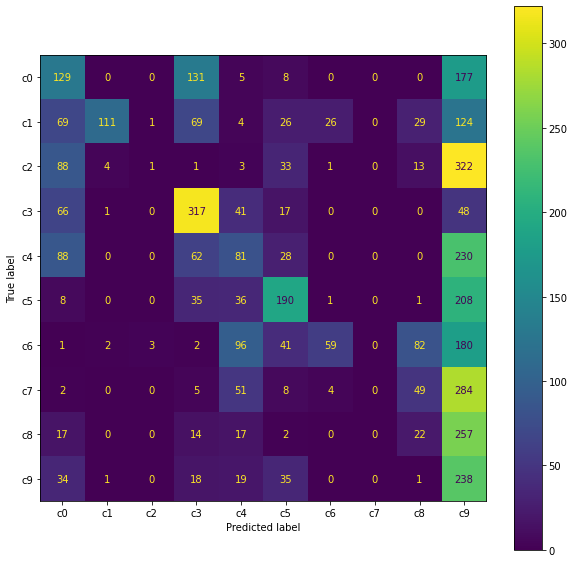

In [8]:
model.fit_model(model.vgg16, x_train, y_train, EPOCHS, BATCH_SIZE, VERBOSE)
model.evaluate_model(model.vgg16, x_test, y_test, BATCH_SIZE)